In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plts
from matplotlib.colors import ListedColormap
matplotlib.rcParams['figure.dpi'] = 65

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

Loading the dataframes exported in the previous part...

In [2]:
df = pd.read_pickle('./dataset/part1_df.pkl')
mdf = pd.read_pickle('./dataset/part1_mdf.pkl')
fdf = pd.read_pickle('./dataset/part1_fdf.pkl')

- `df` is the dataframe containing tournaments, matches and players' info
- `mdf` and `fdf` are, respectively, the list of male and female players

---

# Data Understanding and Data Preparation (Part II)

## Addressing simple Syntactic and Semantic Issues

Before starting to check the dependencies between features we have to *normalize* the `string` fields by removing extra spaces and lowering all the texts.

In [3]:
def strip_column(col):
    x = col.str.replace('\s+', ' ', regex=True)
    x = x.str.strip()
    x = x.str.lower()
    return x

df_str_col = df.select_dtypes(exclude=[np.number, np.timedelta64, np.datetime64])
mdf_str_col = mdf.select_dtypes(exclude=[np.number, np.timedelta64, np.datetime64])
fdf_str_col = fdf.select_dtypes(exclude=[np.number, np.timedelta64, np.datetime64])

for x in df_str_col.columns:
    df[x] = strip_column(df[x])
for x in mdf_str_col.columns:
    mdf[x] = strip_column(mdf[x])
for x in fdf_str_col.columns:
    fdf[x] = strip_column(fdf[x])

## Checking & Fixing Conditional Dependencies

The dependencies we have found exploring the dataset are:

`tourney_id` $\Rightarrow$
- `tourney_name`
- `surface`
- `tourney_date`
- `tourney_spectators`
- `tourney_revenue`

`tourney_id` $\land$ `tourney_sex` $\Rightarrow$
- `draw_size`
- `tourney_level`

`winner_name` (`loser_name`) $\Rightarrow$
- `winner_hand` (`loser_hand`)
- `winner_ioc` (`loser_ioc`)
- `winner_ht` (`loser_ht`)

but since we don't have the `tourney_sex` feature indicating if the tourney we are referring its the male *or* female competition we need to extract a <u>preliminary</u> version of the *player list*, in this way, knowing the sex associated to each player we can determine if that match is part of the male or female tournament, so the `tourney_sex`.

Furthermore, with a player list we will implicitly verify the last block of dependencies.

### Towards an early player list

We start by taking the concatenation (without duplicates) of `winner_name` and `loser_name` with the extra info associated (so the `id`, `hand`, `ioc` and `ht`), in this way we have **all and only** the players who will appear in the player list, while taking the players in the male and female dataset we won't have this guarantee.  

In [4]:
winners = df[["winner_id", "winner_name", "winner_hand", "winner_ioc", "winner_ht"]].copy()
winners.columns = ["id", "name", "hand", "ioc", "ht"]

losers = df[["loser_id", "loser_name", "loser_hand", "loser_ioc", "loser_ht"]].copy()
losers.columns = ["id", "name", "hand", "ioc", "ht"]

players_from_match = pd.concat([winners, losers]).drop_duplicates()
players_from_match = players_from_match.dropna(how='any', subset=['id', 'name'])
display(players_from_match)

,id,name,hand,ioc,ht
0,105453,kei nishikori,r,jpn,178
1,106421,daniil medvedev,r,rus,198
3,104542,jo-wilfried tsonga,r,fra,188
5,104871,jeremy chardy,r,fra,188
8,200282,alex de minaur,r,aus,183
...,...,...,...,...,...
186100,202503,luksika kumkhum,r,<NA>,<NA>
186101,201648,naomi broady,r,<NA>,<NA>
186114,211411,nina stojanovic,r,<NA>,<NA>
186115,202614,jacqueline cako,<NA>,<NA>,<NA>


However this could lead to **possible homonyms**, so we have to check them explicitly. In order to do this:
1. Get from `players_from_match` the list of all the players with names appearing more than once 
2. From this list remove all the entries with the same `id` and `name` but "extra" info associated divergent (they are with high probability the same person)
3. From this list remove all the entries with the same `name`, `hand`, `ioc` and `ht` but different `id`

The resulting list represents all the **possible** homonyms.

In [5]:
duplicate_names = players_from_match.groupby(['name']).size().loc[lambda x: x>1]
possible_namesakes = players_from_match[players_from_match['name'].isin(duplicate_names.index)].sort_values('name')
possible_namesakes = possible_namesakes.drop_duplicates(subset=['id', 'name'], keep=False)
possible_namesakes = possible_namesakes.drop_duplicates(subset=['name', 'hand', 'ioc', 'ht'], keep=False)
display(possible_namesakes)

,id,name,hand,ioc,ht
51441,223126,ekaterina makarova,<NA>,rus,<NA>
6213,201505,ekaterina makarova,l,rus,178
145091,222943,eleni fasoula,<NA>,kaz,<NA>
145085,222942,eleni fasoula,<NA>,gre,<NA>
19073,219835,hei ching claudia ng,<NA>,hkg,<NA>
54654,216586,hei ching claudia ng,r,hkg,<NA>
151774,222845,matylda burylo,<NA>,pol,<NA>
154358,222066,matylda burylo,<NA>,nor,<NA>


Following a search on the web we didn't find any possible homonyms. Let's see if there are `id` with multiple names, maybe there could be spelling mismatches or extra info discording.

In [6]:
duplicate_ids = players_from_match[players_from_match['id'].isin(players_from_match.groupby(['id']).size().loc[lambda x: x>1].index)].sort_values('id')
display(duplicate_ids)

,id,name,hand,ioc,ht
387,105676,david goffin,r,bel,180
31970,105676,david goffin,r,bel,163
78458,200033,kushaan nath,r,ind,<NA>
437,200033,serena williams,r,usa,175
1543,201518,yanina wickmayer,r,bel,182
...,...,...,...,...,...
180881,223184,vanessa ersoz,<NA>,swe,<NA>
180480,223208,eva shaw,<NA>,gbr,<NA>
64643,223208,eva shaw,r,gbr,<NA>
169122,223336,weronika baszak,r,pol,<NA>


In [7]:
# same id but different names
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(duplicate_ids[~duplicate_ids[["id", "name"]].duplicated(keep=False)])

,id,name,hand,ioc,ht
78458,200033,kushaan nath,r,ind,<NA>
437,200033,serena williams,r,usa,175
72621,202273,anurag nenwani,r,ind,<NA>
162151,202273,liga dekmeijere,r,lat,<NA>
14540,202277,mariana correa,r,ecu,<NA>
64866,202277,damien wenger,<NA>,sui,<NA>
85570,202349,kai lemstra,<NA>,ger,<NA>
38530,202349,rushmi chakravarthi,r,ind,<NA>
83920,202359,marvin moeller,<NA>,ger,<NA>
24424,202359,chin wei chan,r,tpe,<NA>


We found a typing error for the player *Alena Fomina*, appearing in the dataset also as *Alona Fomina*.

In [8]:
df["winner_name"] = df["winner_name"].str.replace("alona fomina", "alena fomina")
df["loser_name"] = df["loser_name"].str.replace("alona fomina", "alena fomina")
players_from_match["name"] = players_from_match["name"].str.replace("alona fomina", "alena fomina")

However, we can't do anything about players with typing errors and different ids.

#### Adding the Players' Sex

To associate a player with its sex we have to exploit the *male* and *female* datasets provided and the following idea:
* concatenate the two datasets adding a feature indicating the `sex` of the player (so if the name comes from the male or female dataset)
**NOTE**: there will be same players with two entries, one as male and one as female since they appear in both the datasets (errors or homonyms? we we'll look into it)
* **join** this list with the one obtained in the previous section as all and only the players appearing in the matches. In this way we we'll get rid of all the players in `mdf` and `fdf` not appearing in the dataset.

In [9]:
mdf['sex'] = 'm'
fdf['sex'] = 'f'
mdf['sex'] = mdf['sex'].convert_dtypes()
fdf['sex'] = fdf['sex'].convert_dtypes()

players_from_sex = pd.concat([mdf, fdf]).copy()
display(players_from_sex)

,name,surname,sex
0,gardnar,mulloy,m
1,pancho,segura,m
2,frank,sedgman,m
3,giuseppe,merlo,m
4,richard pancho,gonzales,m
...,...,...,...
46167,kathleen,allen,f
46168,mrs,dransfield,f
46169,jessie,greene,f
46170,mary,trumbull,f


In [10]:
players_from_sex['fullname'] = players_from_sex['name'] + ' ' + players_from_sex['surname']
players_from_sex.drop(columns=['name', 'surname'], inplace=True)

In [11]:
players = pd.merge(players_from_match, players_from_sex, how='left', left_on = 'name', right_on='fullname')
display(players)

,id,name,hand,ioc,ht,sex,fullname
0,105453,kei nishikori,r,jpn,178,m,kei nishikori
1,106421,daniil medvedev,r,rus,198,m,daniil medvedev
2,104542,jo-wilfried tsonga,r,fra,188,<NA>,<NA>
3,104871,jeremy chardy,r,fra,188,m,jeremy chardy
4,200282,alex de minaur,r,aus,183,m,alex de minaur
...,...,...,...,...,...,...,...
10161,202503,luksika kumkhum,r,<NA>,<NA>,f,luksika kumkhum
10162,201648,naomi broady,r,<NA>,<NA>,f,naomi broady
10163,211411,nina stojanovic,r,<NA>,<NA>,f,nina stojanovic
10164,202614,jacqueline cako,<NA>,<NA>,<NA>,f,jacqueline cako


Cleaning up the unnecessary fields...

In [12]:
players.drop(columns=["fullname"], inplace=True)
players.rename(columns={"name" : "fullname"}, inplace=True) # we want to keep the null joined names
players.drop_duplicates(subset=["fullname", "hand", "ioc", "ht", "sex"], inplace=True)

We look for all the players whose name appears in both the male and female datasets, dropping the ones with wrong sex by performing a web search.

In [13]:
players_with_both_sex = players.groupby('fullname').sex.nunique()
players[players.fullname.isin(players_with_both_sex[players_with_both_sex > 1].index)].sort_values('fullname')

,id,fullname,hand,ioc,ht,sex
2908,106269,austin smith,<NA>,usa,<NA>,m
2909,106269,austin smith,<NA>,usa,<NA>,f
1166,202686,di zhao,<NA>,chn,<NA>,m
1167,202686,di zhao,<NA>,chn,<NA>,f
3196,134120,kuan yi lee,r,tpe,<NA>,m
3197,134120,kuan yi lee,r,tpe,<NA>,f
7855,202437,yang liu,<NA>,chn,<NA>,m
7856,202437,yang liu,<NA>,chn,<NA>,f
4122,203917,yi liu,<NA>,chn,<NA>,m
4123,203917,yi liu,<NA>,chn,<NA>,f


We have now found an homonym, it is **Kuan Yi Lee**, which are both a male and a female tennis player from Taipei performing with right hand (a needle in the haystack...). 
Looking into the dataset we have found that the female Kuan Yi Lee has only a match in a female tournament, the one with `id` $2019-1059$, for this reason we rename that occurrence appending an *(F)*.

In [14]:
df.loc[(df.winner_name == 'kuan yi lee') & (df.tourney_id == '2019-1059'), 'winner_name'] = 'kuan yi lee (f)'
df.loc[(df.loser_name == 'kuan yi lee') & (df.tourney_id == '2019-1059'), 'loser_name'] = 'kuan yi lee (f)'
players.loc[(players.fullname == 'kuan yi lee') & (players.sex == 'f'), 'fullname'] = 'kuan yi lee (f)'

The other ones aren't homonyms, so we drop the ones with wrong sex and we're done.

In [15]:
players = players[~((players.fullname == 'austin smith') & (players.sex == 'f'))]
players = players[~((players.fullname == 'di zhao') & (players.sex == 'm'))]
players = players[~((players.fullname == 'yang liu') & (players.sex == 'f'))]
players = players[~((players.fullname == 'yi liu') & (players.sex == 'm'))]
players = players[~((players.fullname == 'ziyu zhang') & (players.sex == 'm'))]

A final assert to check everything is fine..

In [16]:
players_with_both_sex = players.groupby('fullname').sex.nunique()
assert len(players[players.fullname.isin(players_with_both_sex[players_with_both_sex > 1].index)].sort_values('fullname')) == 0

#### Fixing Players' Conflicting Infos

Now the second-last thing to do before having an early player list is to fix all the entries of a same player with discording extra info (`hand`, `ioc` and `ht`).

In [17]:
players_with_multi_info = players[players.duplicated(subset="fullname", keep=False)].sort_values('fullname')
display(players_with_multi_info)

,id,fullname,hand,ioc,ht,sex
23,201548,ajla tomljanovic,r,aus,<NA>,f
2823,201548,ajla tomljanovic,r,aus,180,f
9813,206403,alena fomina,r,rus,<NA>,f
1273,206403,alena fomina,r,ukr,<NA>,f
183,216153,amanda anisimova,r,usa,<NA>,f
...,...,...,...,...,...,...
10158,201554,vitalia diatchenko,r,rus,<NA>,f
6124,223336,weronika baszak,<NA>,pol,<NA>,f
5829,223336,weronika baszak,r,pol,<NA>,f
10157,201518,yanina wickmayer,<NA>,bel,182,f


**Idea**: keep the maximum available information for the multiple entries. 

Are there players with more than two set of conflicting infos?

In [18]:
assert (players_with_multi_info['fullname'].value_counts() != 2).sum() == 0

So we can group the sets by two and keep the maximum available information (if one info has a consistent value and the other is *nan* we keep the consistent value), if there are divergent infos (for example a same player appears both as French and Italian..) we just print the player name and we'll manage it manually later.

In [19]:
# we know that each player has MAX 2 rows, no more
for i in range(0, players_with_multi_info.fullname.count(), 2):
    first = players_with_multi_info.iloc[i]
    second = players_with_multi_info.iloc[i + 1]

    first_list = [first['hand'], first['ioc'], first['ht']]
    second_list = [second['hand'], second['ioc'], second['ht']]

    assert(first.fullname == second.fullname)
    out_list = []

    for j in range(0, len(first_list)):
        # if both have the same value, do nothing
        # otherwise take the value non null if any
        # if there are two different values manage them manually

        bit_check = (pd.isna(first_list[j]) and pd.isna(
            second_list[j])) or (first_list[j] == second_list[j])
        if(pd.isna(bit_check)):
            bit_check = True  # bot NaN
        if(bit_check):
            out_list.append(first_list[j])
        elif pd.isna(first_list[j]):
            out_list.append(second_list[j])
        elif pd.isna(second_list[j]):
            out_list.append(first_list[j])

    if(len(out_list) == 3):
        first_index = first.name
        second_index = second.name

        players.loc[first_index, 'hand'] = out_list[0]
        players.loc[first_index, 'ioc'] = out_list[1]
        players.loc[first_index, 'ht'] = out_list[2]
        players = players.drop(index=second_index)
    else:
        # the player has two non-null attributes
        print("Manage manually " + first['fullname'])
pass

Manage manually alena fomina
Manage manually anastasia kulikova
Manage manually david goffin
Manage manually eleni fasoula
Manage manually matylda burylo


These are the players to be managed manually, the other ones are fixed.

In [20]:
l = ["alena fomina", "anastasia kulikova", "david goffin", "eleni fasoula", "matylda burylo"]
players[players.fullname.isin(l)].sort_values("fullname")

,id,fullname,hand,ioc,ht,sex
1273,206403,alena fomina,r,ukr,<NA>,f
9813,206403,alena fomina,r,rus,<NA>,f
1023,214741,anastasia kulikova,<NA>,rus,<NA>,f
4069,214741,anastasia kulikova,l,fin,<NA>,f
148,105676,david goffin,r,bel,180,m
2160,105676,david goffin,r,bel,163,m
4938,222943,eleni fasoula,<NA>,kaz,<NA>,f
9041,222942,eleni fasoula,<NA>,gre,<NA>,f
9259,222845,matylda burylo,<NA>,pol,<NA>,f
9332,222066,matylda burylo,<NA>,nor,<NA>,f


A brief research on the web and we're done...

In [21]:
players = players[~((players.fullname == 'alena fomina') & (players.ioc == 'ukr'))]
players = players[~((players.fullname == 'anastasia kulikova') & (players.ioc == 'rus'))]
players = players[~((players.fullname == 'david goffin') & (players.ht == 163))]
players = players[~((players.fullname == 'eleni fasoula') & (players.ioc == 'kaz'))]
players = players[~((players.fullname == 'matylda burylo') & (players.ioc == 'nor'))]

In [22]:
# final assert just to be 100% sure
assert len(players.groupby('fullname').filter(lambda x: len(x)>1)) == 0

#### Filling Unknown Sexes

It remains only to fix the tennis player which were not in the male/female datasets, so players whose we don't already have a sex associated.

In [23]:
players[players.sex.isna()]

,id,fullname,hand,ioc,ht,sex
2,104542,jo-wilfried tsonga,r,fra,188,<NA>
31,106426,cristian garin,r,chi,185,<NA>
53,104527,stan wawrinka,r,sui,183,<NA>
86,126156,antoine hoang,r,fra,<NA>,<NA>
95,126203,taylor fritz,r,usa,193,<NA>
110,106043,diego schwartzman,r,arg,170,<NA>
136,126207,frances tiafoe,r,usa,188,<NA>
204,124079,pedro martinez,r,esp,<NA>,<NA>
230,144750,lloyd harris,r,rsa,193,<NA>
319,105015,franko skugor,r,cro,193,<NA>


Thanks God they're only males...

In [24]:
males_indexes = players[players.sex.isna()].index.tolist()
players.loc[players.index.isin(males_indexes), 'sex'] = 'm'

In [25]:
assert len(players[players.sex.isna()]) == 0

#### Indexing the Early Players List

Since we're pretty sure that there are no (more) homonyms in the dataset and since the `id` hasn't provided a reliable source of indexing we <u>take the *fullname* as primary indexing key</u>, dropping the `id`s.

In [26]:
assert players['fullname'].duplicated().sum() == 0

In [27]:
players.drop(columns='id', inplace=True)
df.drop(columns=['winner_id', 'winner_hand', 'winner_ioc', 'winner_ht', 'loser_id', 'loser_hand', 'loser_ioc', 'loser_ht'], inplace=True)
players = players.set_index('fullname')
display(players)

,hand,ioc,ht,sex
fullname,,,,
kei nishikori,r,jpn,178,m
daniil medvedev,r,rus,198,m
jo-wilfried tsonga,r,fra,188,m
jeremy chardy,r,fra,188,m
alex de minaur,r,aus,183,m
...,...,...,...,...
risa ozaki,r,<NA>,<NA>,f
marie bouzkova,<NA>,<NA>,<NA>,f
luksika kumkhum,r,<NA>,<NA>,f


### Inferring Matches' Sex

We need to know which is the "sex" of the tournament in order to perform the dependencies verification since at each `tourney_id` corresponds both the male and the female tournament, and now we're able to obtain it.

In [28]:
# we put all the matches as empty for now
df.insert(3, 'sex', '')

In how many matches of our dataset we don't have the name of *at least* one player, and so we can't be fully sure about the sex of the players? 

In [29]:
len(df) - len(df.dropna(how='any', subset=['winner_name', 'loser_name']))

46

How many of these have only one name?

In [30]:
len(df[(df.winner_name.isna() & ~df.loser_name.isna()) | (~df.winner_name.isna() & df.loser_name.isna())])

34

We we'll now make some considerations. Since:
* the ones counted above are a very little portion of the dataset
* ideally we would always have the name of both players in order to avoid inconsistencies about duplicated matches and semantic errors

from now on <u>we will **only** consider matches where both the names of the players appear</u>.

In [31]:
df = df.dropna(how='any', subset=['winner_name', 'loser_name'])

We can now proceed to infer the sex of the tournament using two simple merges over the `winner_name` and `loser_name` against the player list.

In [32]:
temp_df = df[['winner_name', 'loser_name']].copy().dropna(how='any')
temp_df = temp_df.merge(players, left_on="winner_name", right_index=True)
temp_df = temp_df.merge(players, left_on="loser_name", right_index=True)

display(temp_df)

,winner_name,loser_name,hand_x,ioc_x,ht_x,sex_x,hand_y,ioc_y,ht_y,sex_y
0,kei nishikori,daniil medvedev,r,jpn,178,m,r,rus,198,m
8076,kei nishikori,daniil medvedev,r,jpn,178,m,r,rus,198,m
77061,jo-wilfried tsonga,daniil medvedev,r,fra,188,m,r,rus,198,m
5727,jeremy chardy,daniil medvedev,r,fra,188,m,r,rus,198,m
9388,jeremy chardy,daniil medvedev,r,fra,188,m,r,rus,198,m
...,...,...,...,...,...,...,...,...,...,...
184455,eija jaatinen,kaisa jaaskelainen,<NA>,fin,<NA>,f,<NA>,fin,<NA>,f
184456,farkhanda jabeen,shakhnoza jabarova,<NA>,pak,<NA>,f,<NA>,uzb,<NA>,f
184457,anna kabanova,anna kabanen,<NA>,rus,<NA>,f,<NA>,fin,<NA>,f
184458,ekaterina kabanova,diana la,<NA>,rus,<NA>,f,<NA>,swe,<NA>,f


Let's verify that there aren't tournament where it results to have players with different sexes playing each other.

Verifichiamo che non esistano tornei in cui si scontrano giocatori con sesso (inferito precedentemente) diverso

In [33]:
assert len(temp_df[temp_df.sex_x != temp_df.sex_y]) == 0

It's all good. We have the sex of the tournament and we can proceed to the dependencies check.

In [34]:
df['sex'] = temp_df['sex_x'].copy()
df = df.convert_dtypes()

### Running the Dependencies Check

After a long time...

In [35]:
# returns all the rows which don't satisfy 
#           groups => depend
def check_dependencies(df, groups, depend):
    t = df.groupby(groups)[depend].agg([('unique', 'nunique'), ('type', lambda x : ', '.join(map(str, x.unique())))])
    return t[t.unique > 1]

In [36]:
# temp dataset with filled nan
df = df.dropna(subset=['tourney_id'])
temp_df = df.astype(str).fillna(str(-1))

`tourney_id` $\Rightarrow$ `tourney_name` 

In [37]:
check_dependencies(temp_df, 'tourney_id', 'tourney_name')

,unique,type
tourney_id,,
2016-m006,2,"indian wells, indian wells masters"
2016-m007,2,"miami, miami masters"
2016-m009,2,"rome, rome masters"
2016-m010,2,"'s hertogenbosch, s hertogenbosch"
2016-m021,2,"madrid, madrid masters"
2016-m024,2,"cincinnati, cincinnati masters"
2016-o16,2,"olympics, rio olympics"
2017-m006,2,"indian wells, indian wells masters"
2017-m007,2,"miami, miami masters"


Since there are lot of typos in the names, we start by keeping the ones with *Masters* inside.

In [38]:
# we want to keep the names with "masters"
# df[df.tourney_id == '2020-M024']['tourney_name'].unique()
tourneys = check_dependencies(df, 'tourney_id', 'tourney_name')
for t in tourneys.index:
    curr_tourney = df[df.tourney_id == t]
    for name in curr_tourney['tourney_name'].unique():
        if "masters" in name:
            df.loc[df.tourney_id == t, 'tourney_name'] = name

In [39]:
check_dependencies(df, 'tourney_id', 'tourney_name')

,unique,type
tourney_id,,
2016-m010,2,"'s hertogenbosch, s hertogenbosch"
2016-o16,2,"olympics, rio olympics"
2017-m010,2,"'s hertogenbosch, s hertogenbosch"
2018-m010,2,"s hertogenbosch, s-hertogenbosch"
2019-m010,2,"s hertogenbosch, s-hertogenbosch"
2021-581,2,"doha aus open qualies, dubai aus open qualies"


And fixing manually these last misspellings.

In [40]:
df.loc[df.tourney_id == '2016-o16', 'tourney_name'] = 'rio olympics'
df.loc[df.tourney_id == '2021-581', 'tourney_name'] = 'dubai aus open qualies'
df.loc[df.tourney_id.isin(['2016-m010','2017-m010', '2018-m010', '2019-m010']), 'tourney_name'] = '\'s-hertogenbosch'

`tourney_id` $\Rightarrow$
- `surface`
- `tourney_date`
- `tourney_spectators`
- `tourney_revenue`

In [41]:
pd.concat([
    check_dependencies(temp_df, 'tourney_id', 'surface'),
    check_dependencies(temp_df, 'tourney_id', 'tourney_date'),
    check_dependencies(temp_df, 'tourney_id', 'tourney_revenue'),
    check_dependencies(temp_df, 'tourney_id', 'tourney_spectators')
    ])

,unique,type
tourney_id,,


We're good here, the dependencies are satisfied.

`tourney_id` $\land$ `tourney_sex` $\Rightarrow$
- `draw_size`
- `tourney_level`

In [42]:
pd.concat([
    check_dependencies(temp_df, ['tourney_id', 'sex'], 'draw_size'),
    check_dependencies(temp_df, ['tourney_id', 'sex'], 'tourney_level')
])

,,unique,type
tourney_id,sex,,


And we're good here too, <u>the dateset satisfies all the (found) dependencies</u>.

We also want to verify that all the matches with *five sets* are played only in the tournaments where five sets are allowed to be played, so the Grand Slams, the Davis Cup and the Olympics. This will be useful when we deal with the outliers.

In [43]:
t = df[df['best_of'] == 5].drop_duplicates('tourney_name')
t[~t['tourney_name'].str.contains('davis')]

,tourney_id,tourney_name,surface,sex,draw_size,tourney_level,tourney_date,match_num,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
303,2019-580,australian open,hard,m,128,g,2019-01-14,226,<NA>,novak djokovic,...,16,13,3,8,1,9135,2,7480,15583,2781000.18
2576,2019-520,roland garros,clay,m,128,g,2019-05-27,1101,<NA>,novak djokovic,...,12,13,3,9,1,12355,44,1040,14419,1888254.93
3390,2019-540,wimbledon,grass,m,128,g,2019-07-01,100,<NA>,novak djokovic,...,23,15,8,14,1,12415,57,885,8964,1498510.45
4572,2019-560,us open,hard,m,128,g,2019-08-26,100,<NA>,novak djokovic,...,21,13,7,11,1,11685,76,787,17634,4672240.98
86542,2016-o16,rio olympics,hard,m,64,a,2016-08-08,162,<NA>,andy murray,...,14,21,14,23,2,10065,141,410,6657,1208224.34


## Removing Players with Few Matches

Before counting *in how many match each player has played*, let's assure there aren't matches where a player plays against itself.

In [44]:
len(df[df['winner_name'] == df['loser_name']])

6

Let's remove them.

In [45]:
df = df[~(df['winner_name'] == df['loser_name'])]

Now, let's count the number of matches in which every player has played

In [46]:
winners=df.groupby('winner_name').size()
losers=df.groupby('loser_name').size()
players['match_count'] = losers.add(winners,fill_value=0).astype(int)
players['match_count'] = players['match_count'].convert_dtypes()
display(players)

,hand,ioc,ht,sex,match_count
fullname,,,,,
kei nishikori,r,jpn,178,m,283
daniil medvedev,r,rus,198,m,382
jo-wilfried tsonga,r,fra,188,m,197
jeremy chardy,r,fra,188,m,280
alex de minaur,r,aus,183,m,272
...,...,...,...,...,...
risa ozaki,r,<NA>,<NA>,f,219
marie bouzkova,<NA>,<NA>,<NA>,f,315
luksika kumkhum,r,<NA>,<NA>,f,187


And plot the distribution of these counts toghether with some general statistical info

count    10103.00000
mean        36.77284
std         69.39155
min          1.00000
25%          2.00000
50%          5.00000
75%         29.00000
max        387.00000
Name: match_count, dtype: float64

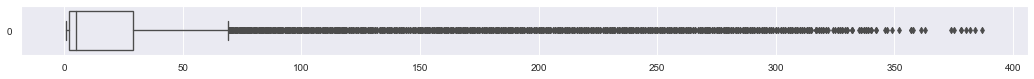

In [47]:
sns.set(rc={'figure.figsize':(20,1)})
ax = sns.boxplot(
    data=players.match_count,
    boxprops={'facecolor':'None'},
    orient='h'
)
display(players.match_count.describe())

Since there are players with very few matches, which could lead to possibly uninteresting features in the player list, we will remove the ones which are in the second quartile, so the ones with *less than six matches*. However, we will not remove the matches where they appear since it would produce a loss of information for the opponent.

In [48]:
players_to_delete = players[players.match_count < 6].index

In [49]:
(len(players_to_delete) * 100) / len(players)

50.242502227061266

Since we are going to remove 50% of players, let's comfort ourselves by computing the actual percentage ofmatches in which these players actually played:

In [50]:
(len(df[df.winner_name.isin(players_to_delete) | df.loser_name.isin(players_to_delete)]) * 100) / len(df)

5.411341638045198

This means that $50\%$ of players contributed to just $5.4\%$ of all the matches contained in the dataset.

We should also remove those matches; however, we decide not to do so as to avoid a loss of information for theopponents. The solution, is to only remove their names

In [51]:
df.loc[df.winner_name.isin(players_to_delete),["winner_name"]]=pd.NA
df.loc[df.loser_name.isin(players_to_delete),["loser_name"]]=pd.NA

In [52]:
players.drop(players_to_delete, inplace=True)

## Inferring Players' Birthdays

To perform future analysis which will need as information the age of the players (for example if we want to see how the performances change when a player gets older, ...) we want to extract their date of birth, or at least an approximation of it.

In order to do this we start by extracting from the dataset all the pairs (`winner/loser_age`, `tourney_date`) relating to each player.

In [53]:
winners = df.loc[df.winner_name.isin(players.index), ["winner_name", "winner_age", "tourney_date"]].rename(columns={"winner_name":"fullname", "winner_age":"age"})
losers = df.loc[df.loser_name.isin(players.index), ["loser_name", "loser_age", "tourney_date"]].rename(columns={"loser_name":"fullname", "loser_age":"age"})

ages = pd.concat([winners, losers])
ages.reset_index(drop=True, inplace=True)
ages["age"] = pd.to_timedelta(np.array(ages["age"]) * 365, unit="days", errors="coerce")
display(ages)

,fullname,age,tourney_date
0,kei nishikori,34675 days 00:00:00,2018-12-31
1,daniil medvedev,8353 days 06:41:08.992665600,2018-12-31
2,kei nishikori,10586 days 17:58:16.509993600,2018-12-31
3,jo-wilfried tsonga,12302 days 13:45:57.290054399,2018-12-31
4,daniil medvedev,8353 days 06:41:08.992665600,2018-12-31
...,...,...,...
360826,eleana yu,5840 days 23:59:00.862828800,2020-11-09
360827,jessica livianu,8290 days 07:43:14.659680,2020-11-09
360828,tara moore,10314 days 22:26:21.930892800,2020-11-09
360829,chanelle van nguyen,9784 days 07:09:43.983244800,2020-11-09


We remove from `ages` all the instances where at least one between `age` and `tourney_date` is unknown, since it would be a meaningless pair.

In [54]:
ages.dropna(subset=['age', 'tourney_date'], inplace=True)

Thus, we can calculate the *birthday date* as (`age` $+$ `tourney_date`)

**NOTE**: we'll possibly have more than one birthday per player

In [55]:
ages["birthday"] = ages["tourney_date"] - ages["age"]
display(ages)

,fullname,age,tourney_date,birthday
0,kei nishikori,34675 days 00:00:00,2018-12-31,1924-01-24 00:00:00.000000000
1,daniil medvedev,8353 days 06:41:08.992665600,2018-12-31,1996-02-16 17:18:51.007334400
2,kei nishikori,10586 days 17:58:16.509993600,2018-12-31,1990-01-05 06:01:43.490006400
3,jo-wilfried tsonga,12302 days 13:45:57.290054399,2018-12-31,1985-04-25 10:14:02.709945601
4,daniil medvedev,8353 days 06:41:08.992665600,2018-12-31,1996-02-16 17:18:51.007334400
...,...,...,...,...
360825,emina bektas,10079 days 02:18:58.397904,2020-11-09,1993-04-05 21:41:01.602096000
360826,eleana yu,5840 days 23:59:00.862828800,2020-11-09,2004-11-12 00:00:59.137171200
360827,jessica livianu,8290 days 07:43:14.659680,2020-11-09,1998-02-27 16:16:45.340320000
360828,tara moore,10314 days 22:26:21.930892800,2020-11-09,1992-08-13 01:33:38.069107200


Now, for each distinct player we calculate the *average* and *variance* of **all** its birthdays calculated above. Furthermore, we also take che count of the number of entries associated for each player.

In [56]:
birthdays = ages.copy()
birthdays["birthday"] = birthdays["birthday"].values.astype(np.int64)
birthdays = birthdays.groupby("fullname")["birthday"].agg(['mean', 'std', 'count'])
birthdays["mean"] = pd.to_datetime(birthdays["mean"])
birthdays["std"] = pd.to_timedelta(birthdays["std"])
display(birthdays)

,mean,std,count
fullname,,,
aaron addison,1995-11-17 11:24:28.358875648,0 days 10:17:43.575732364,11
aayushi tanwar,2000-03-20 00:03:17.125473664,0 days 04:54:29.320663993,6
abbie myers,1994-07-23 22:53:59.665801088,0 days 07:41:27.715461551,157
abhinav sanjeev shanmugam,1998-11-19 21:20:04.927741824,0 days 06:09:31.576005228,16
abigail desiatnikov,2001-01-25 21:24:01.478541696,0 days 02:37:24.966099236,12
...,...,...,...
zoi spyrou,2003-05-09 05:41:21.313953664,0 days 09:36:41.631318038,6
zorica spasojevic,1999-10-12 08:58:09.117128320,0 days 03:17:33.753059632,7
zoziya kardava,2001-07-19 15:05:58.047760000,0 days 07:11:24.416060807,78


### Fixing Birthdays with High Variance

An high variance in the birthday date calculated as the average of all the entries, likely indicates the presence of one or more pairs (`age`, `tourney_date`) **outliers**. We will manage them as follows:

* (a) if the variance is *less than 5 days*, then we reconduct this to the presence of leap years during the life of the players.
* (b) if the variance is *higher or equal than 5 days and the number of matches is $> 30$*, we consider as outliers and remove all its birthdays out of the interval $[(Q1 - 1.5 IQR)), (Q3 + 1.5 IQR)]$
* (c) if the variance is *higher than 5 days and the number of matches is $<30$*, we'll manage manually the outliers.

We start from the case (b).

In [57]:
def getOutliersIndices(dataColumn):
    q1 = dataColumn.quantile(0.25)
    q3 = dataColumn.quantile(0.75)
    iqr = q3 - q1
    return dataColumn[(dataColumn < (q1 - 1.5 * iqr)) | (dataColumn > (q3 + 1.5 * iqr))].index

In [58]:
caseBplayers = birthdays[(birthdays["std"] >= pd.Timedelta(days=5)) & (birthdays["count"] >= 30)].index

for player in caseBplayers:
    ages = ages[~ages.index.isin(getOutliersIndices(ages.loc[ages.fullname == player, 'birthday']))]

We recalculate the dataframe of the birthdays since the removal of the outliers of (b).

In [59]:
birthdays = ages.copy()
birthdays["birthday"] = birthdays["birthday"].values.astype(np.int64)
birthdays = birthdays.groupby("fullname")["birthday"].agg(['mean', 'std', 'count'])
birthdays["mean"] = pd.to_datetime(birthdays["mean"])
birthdays["std"] = pd.to_timedelta(birthdays["std"])

We verify that there are no more players in the case (b).

In [60]:
assert birthdays[(birthdays["std"] >= pd.Timedelta(days=4)) & (birthdays["count"] >= 30)].empty

Now it's time to manage manually the case (c).

In [61]:
birthdays[(birthdays["std"] >= pd.Timedelta(days=5)) & (birthdays["count"] < 30)]

,mean,std,count
fullname,,,
andrew paulson,2001-12-29 07:04:03.942944384,71 days 03:46:33.341546058,8
matteo gigante,2002-01-28 07:54:42.135602432,52 days 09:58:21.555096858,16
petr nouza,1998-10-03 17:13:14.661330560,52 days 14:17:24.849340171,16


We have to manage all this players manually.

In [62]:
ages[ages.fullname == 'andrew paulson'].sort_values('birthday')

,fullname,age,tourney_date,birthday
271032,andrew paulson,6858 days 07:15:38.809382399,2020-08-31,2001-11-20 16:44:21.190617601
273725,andrew paulson,7096 days 03:21:04.064918400,2021-04-26,2001-11-20 20:38:55.935081600
273882,andrew paulson,7103 days 03:14:10.101523200,2021-05-03,2001-11-20 20:45:49.898476800
274580,andrew paulson,7145 days 02:32:46.324608,2021-06-14,2001-11-20 21:27:13.675392000
275420,andrew paulson,7201 days 01:37:34.620988800,2021-08-09,2001-11-20 22:22:25.379011200
275599,andrew paulson,7215 days 01:23:46.694198400,2021-08-23,2001-11-20 22:36:13.305801600
89902,andrew paulson,6690 days 10:01:13.920412800,2020-08-17,2002-04-23 13:58:46.079587200
270799,andrew paulson,6690 days 10:01:13.920412800,2020-08-17,2002-04-23 13:58:46.079587200


In [63]:
ages = ages[~((ages.fullname == 'andrew paulson') & (ages.birthday.dt.year == 2002))]

In [64]:
ages[ages.fullname == 'matteo gigante'].sort_values('birthday')

,fullname,age,tourney_date,birthday
270340,matteo gigante,6613 days 11:17:07.514131200,2020-02-17,2002-01-08 12:42:52.485868800
90014,matteo gigante,6802 days 08:10:50.513088,2020-08-24,2002-01-08 15:49:09.486912000
270917,matteo gigante,6802 days 08:10:50.513088,2020-08-24,2002-01-08 15:49:09.486912000
242666,matteo gigante,6823 days 07:50:08.623075200,2020-09-14,2002-01-08 16:09:51.376924800
243336,matteo gigante,6851 days 07:22:32.772777599,2020-10-12,2002-01-08 16:37:27.227222401
90836,matteo gigante,6872 days 07:01:50.882764800,2020-11-02,2002-01-08 16:58:09.117235200
271719,matteo gigante,6872 days 07:01:50.882764800,2020-11-02,2002-01-08 16:58:09.117235200
271727,matteo gigante,6872 days 07:01:50.882764800,2020-11-02,2002-01-08 16:58:09.117235200
273001,matteo gigante,6998 days 04:57:39.548736,2021-03-08,2002-01-08 19:02:20.451264000
273067,matteo gigante,7005 days 04:50:45.585340800,2021-03-15,2002-01-08 19:09:14.414659200


In [65]:
ages = ages[~((ages.fullname == 'matteo gigante') & (ages.birthday.dt.day == 14))]
ages = ages[~((ages.fullname == 'matteo gigante') & (ages.birthday.dt.day == 11))]

In [66]:
ages[ages.fullname == 'petr nouza'].sort_values('birthday')

,fullname,age,tourney_date,birthday
249461,petr nouza,6475 days 13:33:08.500521600,2016-06-06,1998-09-13 10:26:51.499478400
78423,petr nouza,6937 days 05:57:46.941321600,2017-09-11,1998-09-13 18:02:13.058678400
259837,petr nouza,6937 days 05:57:46.941321600,2017-09-11,1998-09-13 18:02:13.058678400
293678,petr nouza,7084 days 03:32:53.717280,2018-02-05,1998-09-13 20:27:06.282720000
288206,petr nouza,7091 days 03:25:59.753884800,2018-02-12,1998-09-13 20:34:00.246115200
108210,petr nouza,7252 days 00:47:18.603139200,2018-07-23,1998-09-13 23:12:41.396860800
108219,petr nouza,7252 days 00:47:18.603139200,2018-07-23,1998-09-13 23:12:41.396860800
288726,petr nouza,7252 days 00:47:18.603139200,2018-07-23,1998-09-13 23:12:41.396860800
102807,petr nouza,7622 days 18:41:38.561251200,2019-07-29,1998-09-14 05:18:21.438748800
283459,petr nouza,7622 days 18:41:38.561251200,2019-07-29,1998-09-14 05:18:21.438748800


In [67]:
ages = ages[~((ages.fullname == 'petr nouza') & (ages.birthday.dt.month == 2))]

We have managed all the outliers, we can recalculate the birthdays and join them with the player list.

In [68]:
birthdays = ages.copy()
birthdays["birthday"] = birthdays["birthday"].values.astype(np.int64)
birthdays = birthdays.groupby("fullname")["birthday"].agg(['mean'])
birthdays["mean"] = pd.to_datetime(birthdays["mean"])
birthdays = birthdays['mean'].rename('birthday')
display(birthdays)

fullname
aaron addison               1995-11-17 11:24:28.358875648
aayushi tanwar              2000-03-20 00:03:17.125473664
abbie myers                 1994-07-23 22:53:59.665801088
abhinav sanjeev shanmugam   1998-11-19 21:20:04.927741824
abigail desiatnikov         2001-01-25 21:24:01.478541696
                                         ...             
zoi spyrou                  2003-05-09 05:41:21.313953664
zorica spasojevic           1999-10-12 08:58:09.117128320
zoziya kardava              2001-07-19 15:05:58.047760000
zsombor piros               1999-10-18 14:50:47.991877760
zuzana zlochova             1990-01-31 01:42:49.800176768
Name: birthday, Length: 4538, dtype: datetime64[ns]

In [69]:
players = players.join(birthdays)
display(players)

,hand,ioc,ht,sex,match_count,birthday
fullname,,,,,,
kei nishikori,r,jpn,178,m,283,1990-01-05 01:27:19.328566784
daniil medvedev,r,rus,198,m,382,1996-02-16 15:36:26.678407296
jo-wilfried tsonga,r,fra,188,m,197,1985-04-25 13:27:46.696454784
jeremy chardy,r,fra,188,m,280,1987-02-20 06:02:28.688781568
alex de minaur,r,aus,183,m,272,1999-02-22 11:12:54.441395840
...,...,...,...,...,...,...
risa ozaki,r,<NA>,<NA>,f,219,1994-04-15 21:39:02.516345856
marie bouzkova,<NA>,<NA>,<NA>,f,315,1998-07-25 23:56:14.338623872
luksika kumkhum,r,<NA>,<NA>,f,187,1993-07-27 00:29:54.367010944


The birthdays format can now be converted in the `YYYY-MM-dd` format.

In [70]:
players['birthday'] = players['birthday'].dt.strftime('%Y-%m-%d')

At this point the fields `winner_age` and `loser_age` are useless and we can remove them from the `df` dataset.

In [71]:
df = df.drop(columns=['winner_age', 'loser_age'])

## Splitting in Normal Form

Since we have checked all the dependencies, in order <u>to remove the redundancies from the dataset</u> we split the dataset in (approximately) a *normal mode* form.

We create two new tables <u>according to the dependencies verification above</u>, one with as *primary keys* (`tourney_id`, `sex`) and one with `tourney_id` as *primary key*.

In [72]:
tourneys_sex_df = df[['tourney_id', 'sex', 'draw_size', 'tourney_level']].copy().drop_duplicates()
assert (tourneys_sex_df.groupby(['tourney_id', 'sex']).size() != 1).sum() == 0
tourneys_sex_df = tourneys_sex_df.set_index(['tourney_id', 'sex'])

tourneys_sex_df.groupby(['tourney_id', 'sex']).nunique().value_counts()

draw_size  tourney_level
1          1                4933
dtype: int64

In [73]:
tourneys_df = df[['tourney_id', 'tourney_name', 'surface', 'tourney_date', 'tourney_spectators', 'tourney_revenue']].copy().drop_duplicates()
assert (tourneys_df.groupby('tourney_id').size() != 1).sum() == 0
tourneys_df = tourneys_df.set_index('tourney_id')

tourneys_df.groupby(['tourney_id']).nunique().value_counts()

tourney_name  surface  tourney_date  tourney_spectators  tourney_revenue
1             1        1             1                   1                  4791
              0        1             1                   1                    62
dtype: int64

In [74]:
df = df.drop(columns=['tourney_name', 'surface', 'tourney_date', 'tourney_spectators', 'tourney_revenue', 'draw_size', 'tourney_level'])

---

# ( Exporting dataframes for part III )

In [75]:
players.to_pickle('./dataset/part2_players.pkl')
tourneys_sex_df.to_pickle('./dataset/part2_tourneys_sex.pkl')
tourneys_df.to_pickle('./dataset/part2_tourneys.pkl')
df.to_pickle('./dataset/part2_matches.pkl')